In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys

sys.path.append("/Users/cosinga/code/figrid/")
sys.path.append("/Users/cosinga/code/sparta_dev/analysis/")
sys.path.append("/Users/cosinga/software/colossus/")
from sparta_tools import sparta
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('WMAP7')

BASE = '/Users/cosinga/sims/sparta_output/'
SAVE = '/Users/cosinga/overleaf/proposal_defense/figures/'
sdata = sparta.load(BASE + "sparta_ptl_tjy.hdf5", load_halo_data = True)

sparta.load: Loading file /Users/cosinga/sims/sparta_output/sparta_ptl_tjy.hdf5.
sparta.load: Loading 19225/19225 halos from SPARTA file (entire array)...


In [2]:
sparta_keys = list(sdata.keys())
ptl = sdata['tcr_ptl']
tjy = ptl['res_tjy']
orb = ptl['res_oct']
hdata = sdata['halos']
nsnaps = sdata['simulation']['n_snaps']
nhalos = hdata.shape[0]

In [3]:
print(tjy.dtype.names)
print(sdata.keys())
print(sdata['halos'].dtype.names)


('first_snap', 'last_snap', 'r', 'tracer_id', 'v', 'vr', 'vt', 'x')
dict_keys(['config', 'simulation', 'anl_hps', 'anl_prf', 'tcr_ptl', 'halos'])
('R200m', 'first_snap', 'id', 'last_snap', 'parent_id', 'position', 'status', 'status_final', 'velocity', 'anl_hps_first', 'anl_hps_n', 'anl_prf_first', 'anl_prf_n', 'ptl_oct_first', 'ptl_oct_n', 'ptl_sbk_first', 'ptl_sbk_n', 'ptl_tjy_first', 'ptl_tjy_n')


In [4]:
import copy
from colossus.halo import mass_so


class PhaseHist(object):
    def __init__(self, sparta_idx, orbinf = 'all'):
        ftcr = hdata['ptl_tjy_first'][sparta_idx]
        ltcr = hdata['ptl_tjy_n'][sparta_idx] + ftcr
        tcr_slc = slice(ftcr, ltcr)
        fsnap = hdata['first_snap'][sparta_idx]
        lsnap = hdata['last_snap'][sparta_idx] + 1
        snap_slc = slice(fsnap, lsnap)
        self.halo_rad = hdata['R200m'][sparta_idx, snap_slc].copy()
        self.r = tjy['r'][tcr_slc, snap_slc].copy()
        self.vr = tjy['vr'][tcr_slc, snap_slc].copy()
        self.z = sdata['simulation']['snap_z'][snap_slc].copy()
        self.norm_type = ''
        self.fsnap = fsnap
        self.lsnap = lsnap
        self.ftcr = ftcr
        self.ltcr = ltcr
        self.alive = self.r > 0

        self.tjy_id = tjy['tracer_id'][tcr_slc]
        
        ftcr_oct = hdata['ptl_oct_first'][sparta_idx]
        ltcr_oct = hdata['ptl_oct_n'][sparta_idx] + ftcr_oct
        oct_slc = slice(ftcr_oct, ltcr_oct)
        
        
      
        self.nperi = orb['n_pericenter'][oct_slc]
        self.lpsnap = orb['last_pericenter_snap'][oct_slc]
        self.oct_id = orb['tracer_id'][oct_slc]
        self.orb_type = orbinf
        self.hist = None
        return
    
    def reset(self):
        tcr_slc = slice(self.ftcr, self.ltcr)
        snap_slc = slice(self.fsnap, self.lsnap)
        self.r = tjy['r'][tcr_slc, snap_slc].copy()
        self.vr = tjy['vr'][tcr_slc, snap_slc].copy()
        self.norm_type = ''
        return
    
    def normPerSnap(self):
        if not self.norm_type == '':
            print('already normed')
            return

        nsnaps = self.halo_rad.shape[1]
        for s in range(nsnaps):
            self.r[:, s] /= self.halo_rad[s]
            mass = mass_so.R_to_M(self.halo_rad[s], self.z[s], '200m')
            vel = np.sqrt(4.3e-6 * mass/self.halo_rad[s])
            self.vr[:, s] /= vel
        self.norm_type = 'per snap'
        return
    
    def normOneSnap(self, snap_idx):
        
        if not self.norm_type == '':
            print("already normed")
            return

        hrad = self.halo_rad[snap_idx]
        self.r /= hrad
        mass = mass_so.R_to_M(hrad, self.z[snap_idx], '200m')
        vel = np.sqrt(4.3e-6 * mass/hrad)
        self.vr /= vel
        self.norm_type = '$z_{norm} = %.1f$'%self.z[snap_idx]
        return
    
    def plotHist(self, ax, snap_slc, rbins, vrbins,
                 cmap = 'inferno', vlim = []):
        if not self.norm_type:
            print('ptl tjy are not normed')
            return
        mask = self.getMask(snap_slc)
        rs = np.ravel(self.r[mask, snap_slc])
        vrs = np.ravel(self.vr[mask, snap_slc])
        hist, xedge, yedge = np.histogram2d(rs, vrs, [rbins, vrbins])
        self.hist = hist
        plt.sca(ax)
        cmap = copy.copy(plt.get_cmap(cmap))

        cmap.set_under('black')
        hist[hist < 1] = 1
        if not vlim:
            norm = mpl.colors.LogNorm(vmin = 1, vmax = np.max(hist))
        else:
            norm = mpl.colors.LogNorm(vmin = vlim[0], vmax = vlim[1])
        plt.imshow(np.flipud(np.rot90(hist)), origin = 'lower', 
            extent = (rbins[0], rbins[-1], vrbins[0], vrbins[-1]),
            aspect='auto', cmap = cmap, norm = norm)
        return

    def getMask(self, snap_slc): # snapshots included in plot
        orb_mask = np.zeros_like(self.alive)
        alive = self.alive[:, snap_slc]

        if self.orb_type == 'all':
            return alive
        else:
            
            not_found_count = 0
            no_peri_count = 0
            peri_after_count = 0
            for i in range(self.tjy_id.shape[0]):
                tjy_id = self.tjy_id[i] # for tjy id
                oct_idx = np.where(self.oct_id == tjy_id)[0] # find index of oct id
                # if oct info not found, assume infalling
                
                if len(oct_idx) == 0:
                    not_found_count+=1
                    continue
                else:
                    oct_idx = oct_idx[0]
                # if nperi == 0, also infalling

                if self.nperi[oct_idx] == 0:
                    no_peri_count += 1
                    continue

                # set false to ones that have not orbited at this snapshot
                prev_peri = self.lpsnap[oct_idx] <= snap_slc
                peri_after_count += int(prev_peri)
                orb_mask[i, snap_slc] =  prev_peri
            
            print("ID not found: %d\n"%not_found_count)
            print("no pericenter:%d\n"%no_peri_count)
            print("pericenter afterward:%d\n"%peri_after_count)
            
            if self.orb_type == 'inf':
                return alive & ~orb_mask[:, snap_slc]
            elif self.orb_type == 'orb':
                return alive & orb_mask[:, snap_slc]
        
                
                
        
    
    def titleHaloInfo(self, ax, **text_kwargs):
        info = (self.z[self.fsnap], self.z[self.lsnap - 1])
        ax.set_title("Halo fsnap:%.1f, lsnap:%.1f"%info, **text_kwargs)
        return
        
    def textPtlInfo(self, ax, pos = [0.95, 0.95], **text_kwargs):
        def_kwargs = dict(
            ha = 'right',
            va = 'top',
            fontsize = 10,
            color = 'white',
            transform = ax.transAxes
        )
        def_kwargs.update(text_kwargs)
        
        # label norm info
        text = '%s\n'%self.norm_type

        # number of particles
        text += '$N_{tot} = %d$'%np.sum(self.hist)
        # orb/inf later
        ax.text(pos[0], pos[1], text, **def_kwargs)
        return



5482
8312
11669
1315
1535
1690
223
2239
1745
1390
180
155
6379
10839
22716


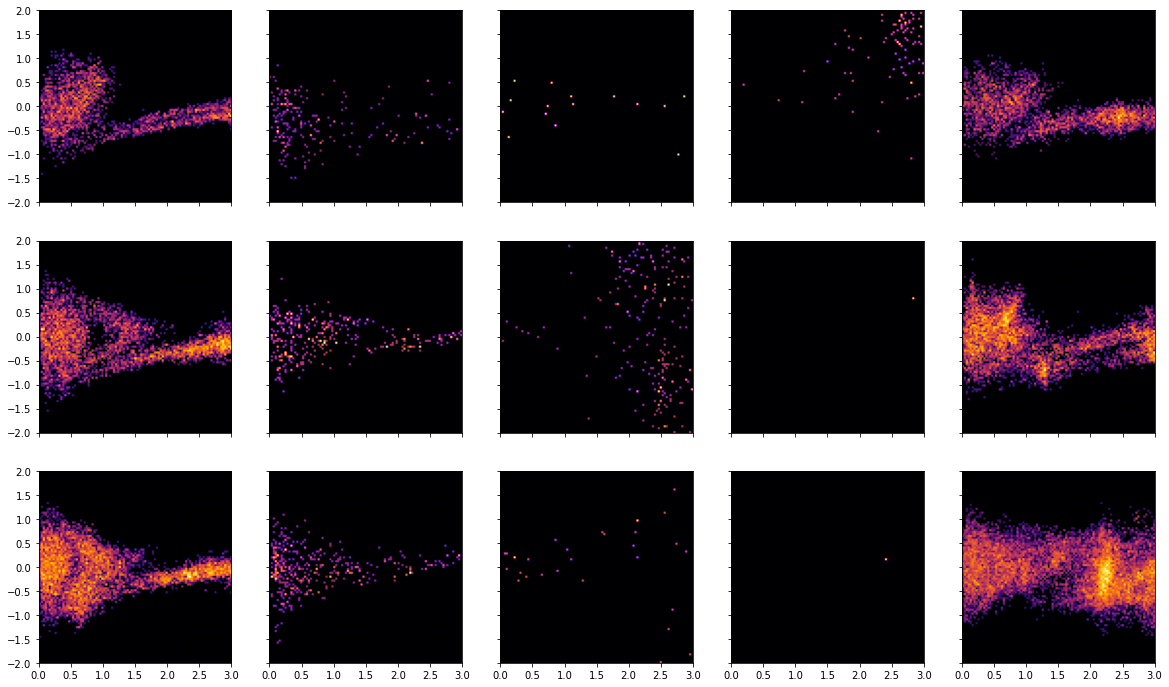

In [5]:
first_mask = sdata['halos']['ptl_tjy_first']>= 0
sparta_idxs = np.where(first_mask)[0]
nhalos = np.sum(first_mask)
nsnaps = 3

fig, axes = plt.subplots(nsnaps, nhalos, sharex=True, sharey=True, figsize = (20, 12))
rbins = np.linspace(0, 3, 100)
vbins = np.linspace(-2, 2, 100)

for j in range(nhalos):
    phist = PhaseHist(sparta_idxs[j])
    mid = (phist.lsnap - phist.fsnap) // 2
    quar = mid // 2
    snaps = [mid, mid+ quar // 2, mid + quar]
    
    for i in range(nsnaps):
        axis = axes[i, j]
        phist.normOneSnap(snaps[i])
        print(np.sum(phist.getMask(snaps[i])))
        phist.plotHist(axis, snaps[i], rbins, vbins)
        phist.reset()


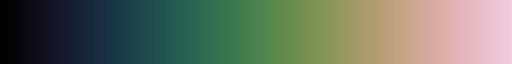

In [6]:
import seaborn as sns
def set_tick_ends(axis):
    xtick_loc = np.arange(0, 3, 0.5)
    xtick_lab = ["%.1f"%x for x in xtick_loc]
    axis.set_xticks(xtick_loc, xtick_lab)

    ytick_loc = np.arange(-1.5, 2, 0.5 )
    ytick_lab = ["%.1f"%y for y in ytick_loc]
    axis.set_yticks(ytick_loc, ytick_lab)
    return

cmap = sns.cubehelix_palette(start=0.2, rot=-1, dark=0, light=0.85, reverse=True, as_cmap=True)
cmap

In [7]:
otype = 'all'
color = 'black'
if color == 'white':
    tcol = 'black'
else:
    tcol = 'white'
orblab = dict(
    all = 'All Particles',
    orb = 'Orbiting',
    inf = 'Infalling'
)
fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1, 1/8]}, figsize = (4.5, 4))

phist = PhaseHist(sparta_idxs[0], otype)
mid = (phist.lsnap - phist.fsnap) // 2
quar = mid // 2
snap = mid + quar // 2
phist.normOneSnap(snap)
norm = mpl.colors.LogNorm(vmin = 1, vmax = 20)
rbins = np.linspace(0, 3, 75)
vbins = np.linspace(-2, 2, 75)
fig.set_facecolor(color)
phist.plotHist(axes[0], snap, rbins, vbins, cmap = cmap, vlim=[norm.vmin, norm.vmax])
smap = mpl.cm.ScalarMappable(norm, cmap)
plt.colorbar(mappable=smap, cax = axes[1])
axes[1].yaxis.set_label_position("right")
axes[1].tick_params(which = 'both', labelright = True, left = False, right = True, labelcolor = tcol, color = tcol)
axes[1].set_ylabel('$N_{\\mathrm{ptl}}$', fontsize = 14, color = tcol)
axes[0].set_ylabel("$V_r / V_{200m}$", fontsize = 14, color = tcol)
axes[0].set_xlabel("$r / R_{200m}$", fontsize = 14, color = tcol)
axes[0].tick_params(which = 'both', direction = 'in', color = 'white', labelcolor = tcol)

if color == 'black':
    for spine in axes[0].spines.values():
        spine.set_edgecolor('white')
    for spine in axes[1].spines.values():
        spine.set_edgecolor('white')
set_tick_ends(axes[0])
plt.text(0.95, 0.95, '%s\nz = %.2f'%(orblab[otype], phist.z[snap]), va = 'top', ha = 'right', color = 'white', transform = axes[0].transAxes, fontsize = 14)
plt.savefig("r-vr_phase_idx%d_snap%03d_%s_%s"%(sparta_idxs[0], snap, otype, color), bbox_inches = 'tight', facecolor = 'auto', dpi = 150)
plt.clf()



<Figure size 324x288 with 0 Axes>

ID not found: 3618

no pericenter:956

pericenter afterward:4971

ID not found: 3618

no pericenter:956

pericenter afterward:4971



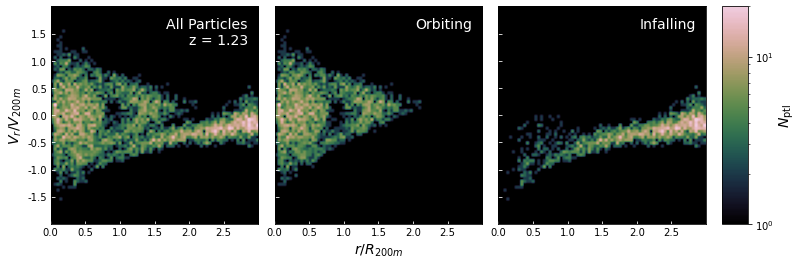

In [116]:
fig, axes = plt.subplots(1, 4, gridspec_kw={'width_ratios' : [1, 1, 1, 1/8], 'wspace':0.1}, figsize = [12.5, 4])
fig.set_facecolor('white')
# standard inputs for each histogram
rbins = np.linspace(0, 3, 75)
vbins = np.linspace(-2, 2, 75)
norm = mpl.colors.LogNorm(vmin = 1, vmax = 20)
smap = mpl.cm.ScalarMappable(norm, cmap)
def_tick = dict(
    which = 'both',
    direction = 'in',
    color = 'white'
)

plt.sca(axes[0])
# set up histogram
phist = PhaseHist(sparta_idxs[0], 'all')
mid = (phist.lsnap - phist.fsnap) // 2
quar = mid // 2
snap = mid + quar // 2
phist.normOneSnap(snap)

phist.plotHist(axes[0], snap, rbins, vbins, cmap, [norm.vmin, norm.vmax])
plt.ylabel("$V_r / V_{200m}$", fontsize = 14)
plt.text(0.95, 0.95, 'All Particles\nz = %.2f'%phist.z[snap], va = 'top', ha = 'right', color = 'white', transform = axes[0].transAxes, fontsize = 14)
axes[0].tick_params(**def_tick)
set_tick_ends(axes[0])

plt.sca(axes[1])
plt.xlabel("$r / R_{200m}$", fontsize = 14)
phist = PhaseHist(sparta_idxs[0], 'orb')
phist.normOneSnap(snap)

phist.plotHist(axes[1], snap, rbins, vbins, cmap, [norm.vmin, norm.vmax])
plt.text(0.95, 0.95, 'Orbiting', va = 'top', ha = 'right', color = 'white', transform = axes[1].transAxes, fontsize = 14)
axes[1].tick_params(**def_tick, labelleft = False)
set_tick_ends(axes[1])

plt.sca(axes[2])
phist = PhaseHist(sparta_idxs[0], 'inf')
phist.normOneSnap(snap)
phist.plotHist(axes[2], snap, rbins, vbins, cmap, [norm.vmin, norm.vmax])

plt.text(0.95, 0.95, 'Infalling', va = 'top', ha = 'right', color = 'white', transform = axes[2].transAxes, fontsize = 14)
axes[2].tick_params(**def_tick, labelleft = False)
set_tick_ends(axes[2])

plt.colorbar(mappable= smap, cax = axes[3])
axes[3].yaxis.set_label_position("right")
axes[3].tick_params(which = 'both', labelright = True, left = False, right = True)
axes[3].set_ylabel('$N_{\\mathrm{ptl}}$', fontsize = 14)
plt.savefig("r-vr_phase_all-orb-inf_white", bbox_inches = 'tight', dpi = 150)


In [1]:
import copy

# halos that we have data for
ftcrs = sdata['halos']['ptl_tjy_first']
ftcrs = ftcrs[ftcrs >= 0]
ltcrs = sdata['halos']['ptl_tjy_n']
ltcrs = ftcrs + ltcrs[ltcrs > 0]

HALO = 2
tcr_slc = slice(ftcrs[HALO], ltcrs[HALO])
sparta_idx = np.where(sdata['halos']['ptl_tjy_first']>= 0)[0][HALO]
fsnap = sdata['halos']['first_snap'][sparta_idx]
lsnap = sdata['halos']['last_snap'][sparta_idx]
snap_slc = slice(fsnap, lsnap)
z = sdata['simulation']['snap_z'][lsnap]
r = tjy['r'][tcr_slc, lsnap].copy()

hrad = sdata['halos']['R200m'][sparta_idx, lsnap].copy()
hmass = mass_so.R_to_M(hrad, z, '200m')
hvel = np.sqrt(4.3e-6 * hmass/hrad)
r /= hrad

vr = tjy['vr'][tcr_slc, lsnap].copy() / hvel

rbins = np.linspace(0, 3, 100)
vbins = np.linspace(-2, 2, 100)
hist, xe, ye = np.histogram2d(np.ravel(r), np.ravel(vr), [rbins, vbins])

cmap = copy.copy(plt.get_cmap('inferno'))

cmap.set_under('black')
hist[hist < 1] = 1
norm = mpl.colors.LogNorm(vmin = 1, vmax = np.max(hist))
plt.imshow(np.rot90(hist), origin = 'lower', extent = (0, 3, -3, 3), aspect='auto', cmap = cmap, norm = norm)
plt.title("Halo Mass %.2e $M_\\odot$"%hmass)
plt.colorbar()

NameError: name 'sdata' is not defined

In [16]:
from colossus.halo import mass_so

def get_normed_phase(mass_cut, snap_idx):
    hrad = hdata['R200m'][:, snap_idx]
    ftcrs = hdata['ptl_tjy_first']
    ntcrs = hdata['ptl_tjy_n']
    r = tjy['r'][:, snap_idx]
    vr = tjy['vr'][:, snap_idx]
    r_norm = np.zeros_like(r) - 1
    vr_norm = np.zeros_like(vr) - 1e20
    for i in range(nhalos):
        
        z = sdata['simulation']['snap_z'][snap_idx]
        mavg = np.sum(mass_cut) / 2
        ravg = mass_so.M_to_R(mavg, z, '200m')
        rmin = mass_so.M_to_R(mass_cut[0], z, '200m')
        rmax = mass_so.M_to_R(mass_cut[1], z, '200m')
        if hrad[i] >= rmin and hrad[i] < rmax:
            ift = ftcrs[i]
            ilt = ift + ntcrs[i]
            
            r_norm[ift:ilt] = r[ift:ilt] / ravg
            vavg = np.sqrt(4.3e-6 * mavg/ravg)
            vr_norm[ift:ilt] = vr[ift:ilt] / vavg
    
    return r_norm, vr_norm
            


In [20]:
# fid_cut = (1e11, 1e13)
fid_cut = (1e8, np.inf)
r, vr = get_normed_phase(fid_cut, 184)
inval = r <= 0
rbins = np.linspace(0, 3, 25)
vbins = np.linspace(-3, 3, 25)
hist, xe, ye = np.histogram2d(r, vr, [rbins, vbins])
import copy

cmap = copy.copy(plt.get_cmap('inferno'))

cmap.set_under('black')
norm = mpl.colors.LogNorm(vmin = 1, vmax = np.max(hist))
plt.imshow(np.rot90(hist), origin = 'lower', extent = (0, 3, -3, 3), aspect=1/2, cmap = cmap, norm = norm)
plt.title("Raw Data")


/var/folders/79/98r4p1nd3v19cl5z3dbndg_c0000gn/T/ipykernel_69855/3474546308.py:23: RuntimeWarning: invalid value encountered in scalar divide
  vavg = np.sqrt(4.3e-6 * mavg/ravg)


Text(0.5, 1.0, 'Raw Data')

Error in callback <function _draw_all_if_interactive at 0x11708c550> (for post_execute):


ValueError: vmin must be less or equal to vmax

ValueError: vmin must be less or equal to vmax

<Figure size 640x480 with 1 Axes>

In [19]:
rad_issue = (r > 1) & (r <1.1)
print(tjy['last_snap'][rad_issue])

[189 189 189 189 189 189 189 189 189 189 189 189 189 189 189 189 189 189
 189 189 189 189 189 189 189 187 189 189 189 189 189 189 189 189 189 189
 189 189 189 189 187 189 189 189 189 189 189 189 189 189 188 189 189 189
 189 189 188 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192
 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192
 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192
 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192
 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192
 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192
 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192
 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192
 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192
 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192 192
 192 192 192 192 192 192 192 192 192 192 192 192 19

In [27]:


ftcrs = hdata['ptl_tjy_first']
ntcrs = hdata['ptl_tjy_n']
r_norm = np.zeros_like(tjy['r']) - 1
vr_norm = np.zeros_like(tjy['vr']) - 1e20

r200 = sdata['halos']['R200m']
mass = np.zeros_like(r_norm) - 1
is_host = np.zeros_like(r_norm, dtype = bool)
    
for j in range(sdata['simulation']['n_snaps']):
    for i in range(len(ftcrs)):
        ift = ftcrs[i]
        ilt = ift + ntcrs[i]
        ir200 = r200[i, j]
        z = sdata['simulation']['snap_z'][j]

        if ilt <= 0:
            continue
        if ir200 < 0:
            continue
        im200 = mass_so.R_to_M(ir200, z, '200m')
        iv200 = np.sqrt(4.3e-6 * im200/ir200) # G in sm / kpc (km / s) squared
        r_norm[ift:ilt, j] = tjy['r'][ift:ilt, j] / ir200
        vr_norm[ift:ilt, j] = tjy['vr'][ift:ilt, j] / iv200
        mass[ift:ilt, j] = im200
        is_host[ift:ilt, j] = hdata['status'][i, j] == 10


(array([297., 213., 154., 146., 149., 166., 169., 193., 212., 314., 518.,
        441., 393., 261., 217., 206., 147., 121.,  76.,  68.,  37.,  20.,
         30.,   8.,   6.]),
 array([2.27030879e-03, 1.58858433e-01, 3.15446585e-01, 4.72034693e-01,
        6.28622830e-01, 7.85210967e-01, 9.41799104e-01, 1.09838724e+00,
        1.25497532e+00, 1.41156352e+00, 1.56815159e+00, 1.72473979e+00,
        1.88132787e+00, 2.03791595e+00, 2.19450426e+00, 2.35109234e+00,
        2.50768042e+00, 2.66426849e+00, 2.82085657e+00, 2.97744489e+00,
        3.13403296e+00, 3.29062104e+00, 3.44720912e+00, 3.60379744e+00,
        3.76038551e+00, 3.91697359e+00]),
 <BarContainer object of 25 artists>)

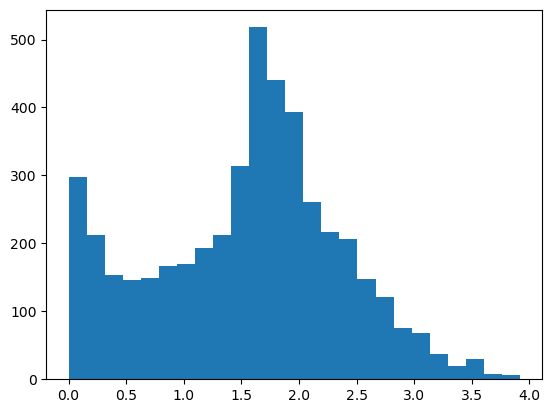

In [28]:
inval = r_norm < 0
nperi = np.zeros_like(inval, dtype = bool)
nperi[:, 170] = True

plt.hist(r_norm[~inval & nperi], bins = 25)

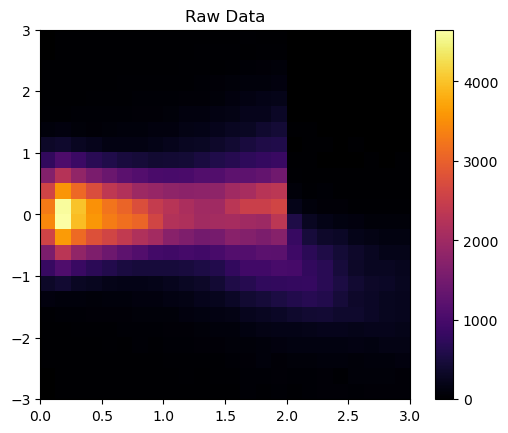

In [29]:
# no mass or snapshot cuts

# mask invalid values
inval = r_norm < 0

rbins = np.linspace(0, 3, 25)
vbins = np.linspace(-3, 3, 25)
hist, xe, ye = np.histogram2d(r_norm[~inval], vr_norm[~inval], [rbins, vbins])
import copy

cmap = copy.copy(plt.get_cmap('inferno'))

cmap.set_under('black')
norm = mpl.colors.Normalize(vmin = 0, vmax = np.max(hist))
hist[hist <= 0] = -1
plt.imshow(np.rot90(hist), origin = 'lower', extent = (0, 3, -3, 3), aspect=1/2, cmap = cmap, norm = norm)
plt.title("Raw Data")
plt.colorbar()

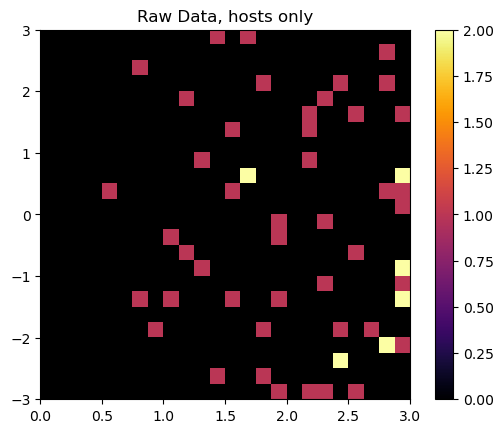

In [23]:
# only hosts

# 135

inval = r_norm < 0

rbins = np.linspace(0, 3, 25)
vbins = np.linspace(-3, 3, 25)
hist, xe, ye = np.histogram2d(r_norm[~inval & is_host], vr_norm[~inval & is_host], [rbins, vbins])
import copy

cmap = copy.copy(plt.get_cmap('inferno'))

cmap.set_under('black')
norm = mpl.colors.Normalize(vmin = 0, vmax = np.max(hist))
hist[hist <= 0] = -1
plt.imshow(np.rot90(hist), origin = 'lower', extent = (0, 3, -3, 3), aspect=1/2, cmap = cmap, norm = norm)
plt.title("Raw Data, hosts only")
plt.colorbar()

In [30]:
min_cut = [1e10, 1e11, 1e12]
max_cut = [1e11, 1e12, 1e13, 1e14]
ncuts = 0
for mn in min_cut:
    for mx in max_cut:
        if mn < mx:
            ncuts += 1



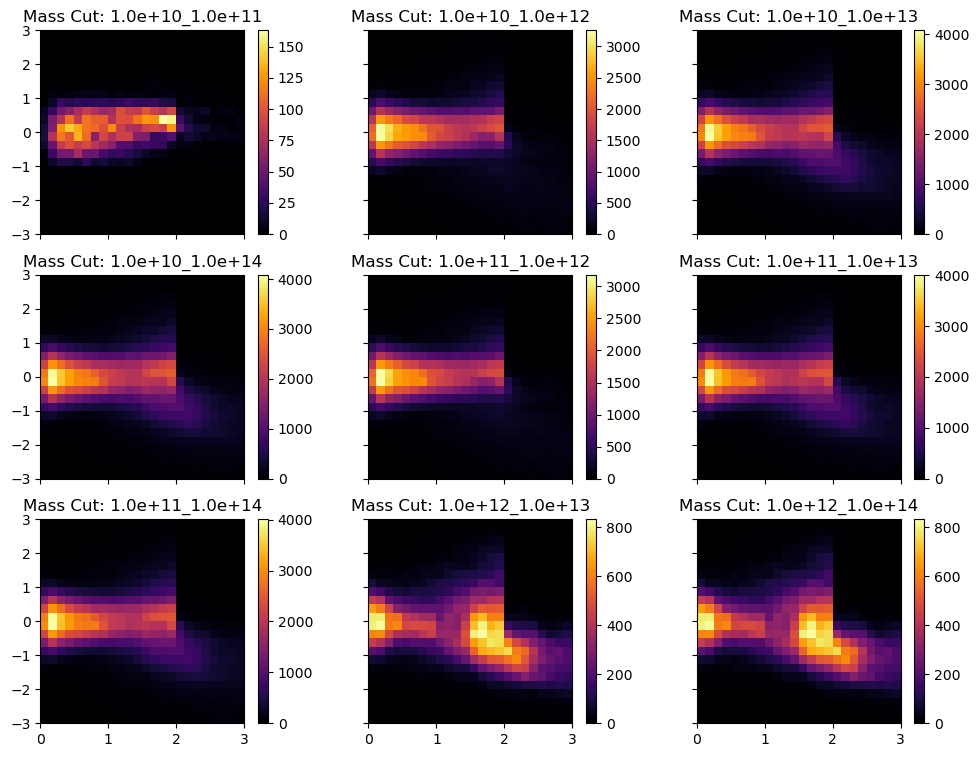

In [31]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize = (12, 9))
axes = np.ravel(axes)
ax_idx = 0

rbins = np.linspace(0, 3, 25)
vbins = np.linspace(-3, 3, 25)
is_log = False
for i, mn in enumerate(min_cut):
    for j, mx in enumerate(max_cut):
        if mn < mx:
            mass_mask = (mass >= mn) & (mass < mx)
            nperi = ~inval & mass_mask & is_host
            hist, xe, ye = np.histogram2d(r_norm[nperi], vr_norm[nperi], [rbins, vbins])
            
            cmap = copy.copy(plt.get_cmap('inferno'))
            cmap.set_under('black')
            if is_log:
                zmask = hist <= 0
                hist = np.log10(hist)
                hist[zmask] = -1
            norm = mpl.colors.Normalize(vmin = 0, vmax = np.max(hist))
            axis = axes[ax_idx]
            axis.imshow(np.rot90(hist), origin = 'lower', extent = (0, 3, -3, 3), aspect=1/2, cmap = cmap, norm = norm)
            axis.set_title("Mass Cut: %.1e_%.1e"%(mn, mx))
            smap = mpl.cm.ScalarMappable(cmap = cmap, norm = norm)
            plt.colorbar(mappable=smap, ax=axis)
            ax_idx += 1
# plt.xlabel("$V_r$")
# plt.ylabel("r")

In [ ]:

fid_cut = (1e11, 1e13)
mn_snap = [100, 150, 184]
mx_snap = [184]

fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize = (4, 9))
axes = np.ravel(axes)
ax_idx = 0

mass_mask = (mass >= fid_cut[0]) & (mass < fid_cut[1])
rbins = np.linspace(0, 3, 25)
vbins = np.linspace(-3, 3, 25)

for i, mn in enumerate(mn_snap):
    for j, mx in enumerate(mx_snap):
        snap_mask = np.zeros_like(mass_mask, dtype = bool)
        if mn == mx:
            snap_mask[:, mn] = True
        else:
            snap_mask[:, mn:mx] = True
        nperi = ~inval & mass_mask & is_host & snap_mask
        print(np.sum(nperi))
        hist, xe, ye = np.histogram2d(r_norm[nperi], vr_norm[nperi], [rbins, vbins])

        cmap = copy.copy(plt.get_cmap('inferno'))
        cmap.set_under('black')
        if is_log:
            zmask = hist <= 0
            hist = np.log10(hist)
            hist[zmask] = -1
        norm = mpl.colors.Normalize(vmin = 0, vmax = np.max(hist))
        axis = axes[ax_idx]
        axis.imshow(np.rot90(hist), origin = 'lower', extent = (0, 3, -3, 3), aspect=1/2, cmap = cmap, norm = norm)
        axis.set_title("Snapshot: %d_%d"%(mn, mx))
        smap = mpl.cm.ScalarMappable(cmap = cmap, norm = norm)
        plt.colorbar(mappable=smap, ax=axis)
        ax_idx += 1
            


In [ ]:
from colossus.halo import mass_so
r200 = sdata['halos']['R200m'][halo_idx, snap_idx]
m200 = mass_so.R_to_M(r200, z, '200m')
radtcr = tjy['r'][ftcr:ltcr, snap_idx]
vrtcr = tjy['vr'][ftcr:ltcr, snap_idx]
vttcr = tjy['vt'][ftcr:ltcr, snap_idx]
tcr_alive = radtcr >= 0


In [ ]:
rbins = np.linspace(0, 3, 25)
hist, edges = np.histogram(radtcr / r200, rbins)
midr = (edges[1:] + edges[:-1]) / 2
plt.plot(midr, hist)

In [ ]:
vbins = np.linspace(-3, 3, 25)
v200 = np.sqrt(4.3e-6 * m200/r200) # G in sm / kpc (km / s) squared

hist, edges = np.histogram(vrtcr / v200, vbins)
midr = (edges[1:] + edges[:-1]) / 2
plt.plot(midr, hist)


In [ ]:
import copy
hist, xedges, yedges = np.histogram2d(radtcr[tcr_alive]/r200, vrtcr[tcr_alive] / v200, [rbins, vbins])
cmap = copy.copy(plt.get_cmap('inferno'))
loghist = np.log10(hist)

cmap.set_under('black')
norm = mpl.colors.Normalize(vmin = 0, vmax = np.max(loghist))
loghist[hist <= 0] = -1
plt.imshow(np.rot90(loghist), origin = 'lower', extent = (0, 3, -3, 3), aspect=1/2, cmap = cmap, norm = norm)
plt.colorbar()

In [ ]:
plt.hist2d(radtcr[tcr_alive]/r200, vrtcr[tcr_alive] / v200, [rbins, vbins])